# Neural Style Transfer
One of the most exciting and fun ideas in computer vision is style transfer, which is simply taking an original images (aka content image) and applying the artistic style of another image (style image) to create a new and visually interesting result (generated image).
We'll see how we can create a code able to perform this task, and we 'll also give you an intuition about the math empowring it.

##  Importing essential libraries

In [1]:
import numpy as np 
from PIL import Image
import tensorflow as tf

## Transfer learning 
In the field of computer vision, a commun useful technique is to use somme powerful model that someone else has implemented and use it for your own task. Here's an example that illustrates the process:
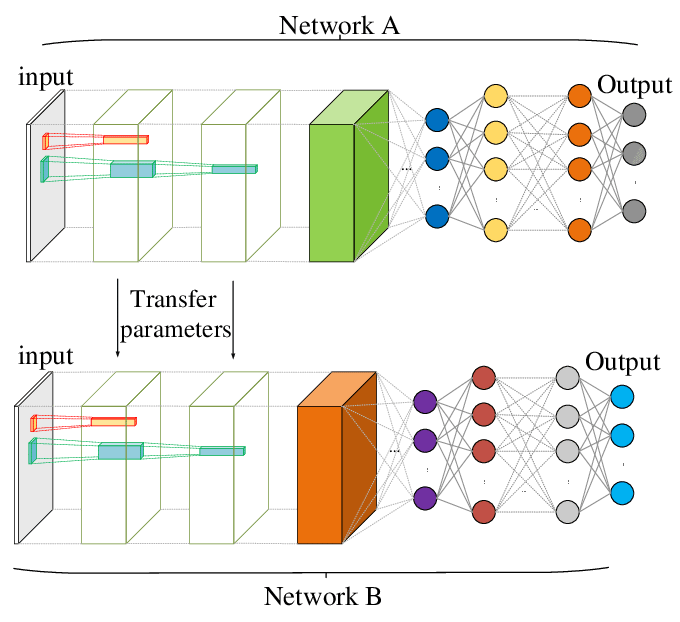
For our case we're going to use VGG-19, since it has 19 layers and has been trained on a large dataset of images so its shallow layers have already learned basic features, and its deep layers have learned complex high level features and luckly that what we exactly need.

In [3]:
#This loads the vgg19 model excluding the last layers (fully connected layers at the end of the model)
vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
vgg19_model.trainable = False 

80134624/80134624 [==============================] - 8s 0us/step
